# 数据输入
### 本文档解决的问题是：加工厂（数量）在空间上的分布，grid → 统计数量 → 做相关性分析，即哪些地方更容易出现加工厂的聚集。目前得出的加工厂数量与其他变量的相关性度不高。建议放大GRID进行另外的尝试

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import box,Polygon
import analysis_tool as tool

In [6]:
gdfs = tool.load_all_gdfs("origin_data")
# print(len(gdfs))
# 文件内容为：gdfs["文件夹名"]
# ├── 00_Boundaries/                     # 边界
# │
# ├── 01_production_farming/             # 农作物（可耕地）
# │
# ├── 02_production_aquaculture/         # 水产养殖（海岸泻湖 + 河口）
# │
# ├── 03_production_livestock/           # 畜牧养殖（草场）
# │
# ├── 04_transformation_industry/        # 食品加工厂（GOOGLE 来源）
# │
# ├── 05_transformation_energy/          # 水厂、电厂、供热等能源基础设施
# │
# ├── 06_logistics_transportation/        # 公共交通 + 港口 + 仓储 + 配送中心
# │
# ├── 07_logistics_roads/                # 可通行道路（MultiDiGraph）
# │
# ├── 08_supply_retail/                  # 超市、市场、批发商等零售终端
# │
# ├── 09_supply_public_services/         # 公共服务设施：学校、医疗、福利
# │
# ├── 10_built_environment/              # 建成区信息（居住、商业、工业）
# │
# ├── 11_consumption_facilities/         # 餐饮、酒店、住宿类消费终端
# │
# ├── 12_consumption_landuse_mix/        # 土地混合度计算所需的 landuse 数据
# │
# ├── 13_waste_treatment/                # 废弃物处理设施：垃圾厂、废水厂


✅  已加载 00_Boundaries: Whole area.shp (1 条记录, 0.08 MB)
✅  已加载 01_production_farming: farming.shp (1647 条记录, 2.90 MB)
✅  已加载 02_production_aquaculture: aquaculture.shp (211 条记录, 2.49 MB)
✅  已加载 03_production_livestock: livestock.shp (1538 条记录, 1.61 MB)
✅  已加载 04_transformation_industry: processing.shp (58 条记录, 0.00 MB)
✅  已加载 05_transformation_energy: energy.shp (147 条记录, 0.03 MB)
✅  已加载 06_logistics_transportation: transportation.shp (656 条记录, 0.28 MB)
✅  已加载 07_logistics_roads: roads_highways.shp (58252 条记录, 6.92 MB)
✅  已加载 08_supply_retail: shop_food_beverage_data.shp (432 条记录, 0.01 MB)
✅  已加载 09_supply_public_services: public_services.shp (911 条记录, 0.02 MB)
✅  已加载 10_built_environment: buildings.shp (189600 条记录, 54.22 MB)
✅  已加载 11_consumption_facilities: consumption_data.shp (2889 条记录, 0.08 MB)
✅  已加载 12_consumption_landuse_mix: landuse_mix.shp (7124 条记录, 2.28 MB)
✅  已加载 13_waste_treatment: impianti_smaltimento_rifiuti.shp (10 条记录, 0.00 MB)


# 创建网格

In [4]:
grid= gpd.read_file(r"processing_data\grid\grid_entropy.geojson")

## 空间连接，存储为 joined_grid.geojson

In [5]:
# 计算面
grid = tool.area_polygons_in_grid(gdfs["01_production_farming"], grid, "farming_area")
grid = tool.area_polygons_in_grid(gdfs["02_production_aquaculture"], grid, "aquaculture_area")
grid = tool.area_polygons_in_grid(gdfs["03_production_livestock"], grid, "pasture_area")
grid = tool.area_polygons_in_grid(gdfs["05_transformation_energy"], grid, "energy_area")
grid = tool.area_polygons_in_grid(gdfs["06_logistics_transportation"], grid, "transportation_area")
grid = tool.area_polygons_in_grid(gdfs["10_built_environment"], grid, "built_area")
grid = tool.area_polygons_in_grid(gdfs["12_consumption_landuse_mix"], grid, "landuse_area")
# 计算各个landuse
gdf_landuse=gdfs["12_consumption_landuse_mix"]
landuse_types = gdf_landuse["landuse"].unique()
for landuse_type in landuse_types:
    sub_gdf = gdf_landuse[gdf_landuse["landuse"] == landuse_type]
    column_name = f"{landuse_type}_area"
    grid = tool.area_polygons_in_grid(sub_gdf, grid, column_name)
# 计算点
grid = tool.count_points_in_grid(gdfs["04_transformation_industry"], grid, "factory_count")
grid = tool.count_points_in_grid(gdfs["08_supply_retail"], grid, "retail_count")
grid = tool.count_points_in_grid(gdfs["09_supply_public_services"], grid, "public_services")
grid = tool.count_points_in_grid(gdfs["11_consumption_facilities"], grid, "consumption_count")
grid = tool.count_points_in_grid(gdfs["13_waste_treatment"], grid, "waste_treatment")
# 计算线
grid = tool.length_lines_in_grid(gdfs["07_logistics_roads"], grid, "road_length")
# 道路交叉点
gdf_intersections = tool.extract_road_intersections(gdfs["07_logistics_roads"])
grid = tool.count_points_in_grid(gdf_intersections, grid, "intersection_count")
# 其他
grid.to_file("processing_data\grid\joined_grid_2500.geojson")

  Calculating area for farming_area...


100%|██████████| 3576/3576 [00:00<00:00, 6240.78it/s]


  Calculating area for aquaculture_area...


100%|██████████| 1430/1430 [00:01<00:00, 1170.52it/s]


  Calculating area for pasture_area...


100%|██████████| 2628/2628 [00:00<00:00, 8737.62it/s]


  Calculating area for energy_area...


100%|██████████| 159/159 [00:00<00:00, 10597.90it/s]


  Calculating area for transportation_area...


100%|██████████| 706/706 [00:00<00:00, 11764.06it/s]

  Calculating area for built_area...



100%|██████████| 196287/196287 [00:15<00:00, 12922.80it/s]


  Calculating area for landuse_area...


100%|██████████| 10391/10391 [00:00<00:00, 10760.99it/s]
g:\CODE\UrbanFood\.venv\lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


  Calculating area for farmland_area...


100%|██████████| 6707/6707 [00:00<00:00, 10772.47it/s]
g:\CODE\UrbanFood\.venv\lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


  Calculating area for meadow_area...


100%|██████████| 304/304 [00:00<00:00, 9209.53it/s]
g:\CODE\UrbanFood\.venv\lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


  Calculating area for residential_area...


100%|██████████| 2476/2476 [00:00<00:00, 10328.63it/s]
g:\CODE\UrbanFood\.venv\lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


  Calculating area for industrial_area...


100%|██████████| 475/475 [00:00<00:00, 8531.21it/s]
g:\CODE\UrbanFood\.venv\lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


  Calculating area for commercial_area...


100%|██████████| 115/115 [00:00<00:00, 11497.54it/s]
g:\CODE\UrbanFood\.venv\lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


  Calculating area for retail_area...


100%|██████████| 110/110 [00:00<00:00, 9998.12it/s]
g:\CODE\UrbanFood\.venv\lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


  Calculating area for construction_area...


100%|██████████| 181/181 [00:00<00:00, 11310.45it/s]
g:\CODE\UrbanFood\.venv\lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


  Calculating area for recreation_ground_area...


100%|██████████| 17/17 [00:00<00:00, 8498.59it/s]
g:\CODE\UrbanFood\.venv\lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


  Calculating area for education_area...


100%|██████████| 6/6 [00:00<00:00, 5994.72it/s]


 Counting points for factory_count...
 Counting points for retail_count...
 Counting points for public_services...
 Counting points for consumption_count...
 Counting points for waste_treatment...
  Calculating total line length for road_length...


提取交叉口: 100%|██████████| 58252/58252 [00:12<00:00, 4705.68it/s]


 Counting points for intersection_count...


# 归一化，储存为 grid_normalized

In [6]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# grid= gpd.read_file(r"processing_data\grid\grid_entropy.geojson")
joined_grid = gpd.read_file("processing_data\grid\joined_grid_2500.geojson")
# joined_grid = gpd.read_file("processing_data\grid\joined_grid.geojson")

cols_to_normalize = [
       'farming_area', 'pasture_area', 'energy_area',
       'transportation_area', 'landuse_area', 'farmland_area',
       'meadow_area', 'residential_area', 'industrial_area', 'commercial_area',
       'retail_area', 'construction_area', 'recreation_ground_area',
       'education_area', 'factory_count', 'retail_count', 'public_services',
       'consumption_count', 'waste_treatment', 'road_length',
       'intersection_count', 'aquaculture_area', 'built_area'
]
# 归一化
scaler = MinMaxScaler()
grid[[f"{col}_norm" for col in cols_to_normalize]] = scaler.fit_transform(joined_grid[cols_to_normalize])

# 计算农业混合度
production_cols = ['farming_area','aquaculture_area','pasture_area']
norm_cols = [f"{col}_norm" for col in production_cols]
def shannon_entropy_production(row):
    p = row[norm_cols].values
    p = np.array(p, dtype=float)
    if p.sum() == 0:
        return 0
    p = p / p.sum()
    return -np.nansum(p * np.log2(p + 1e-9))
grid['entropy_production'] = grid.apply(shannon_entropy_production, axis=1)
# 计算用地混合度
landuse_cols = ['farmland_area',
       'meadow_area', 'residential_area', 'industrial_area', 'commercial_area',
       'retail_area', 'construction_area', 'recreation_ground_area',
       'education_area']
norm_cols_2 = [f"{col}_norm" for col in landuse_cols]
def shannon_entropy_landuse(row):
    p = row[norm_cols_2].values
    p = np.array(p, dtype=float)
    if p.sum() == 0:
        return 0
    p = p / p.sum()
    return -np.nansum(p * np.log2(p + 1e-9))
grid['entropy_landuse'] = grid.apply(shannon_entropy_landuse, axis=1)
print(grid.columns)
# grid = grid[['grid_id','geometry', 'farming_area_norm','aquaculture_area_norm',
#        'pasture_area_norm', 'energy_area_norm', 'transportation_area_norm',
#        'factory_count_norm', 'retail_count_norm', 'public_services_norm',
#        'consumption_count_norm', 'waste_treatment_norm', 'road_length_norm',
#        'intersection_count_norm','built_area_norm',
#        'entropy_production', 'entropy_landuse' ]]
grid = grid[['geometry', 'farming_area_norm','aquaculture_area_norm',
       'pasture_area_norm', 'energy_area_norm', 'transportation_area_norm',
       'factory_count_norm', 'retail_count_norm', 'public_services_norm',
       'consumption_count_norm', 'waste_treatment_norm', 'road_length_norm',
       'intersection_count_norm','built_area_norm',
       'entropy_production', 'entropy_landuse' ]]
grid.to_file("processing_data\grid\grid_normalized_2500.geojson")

Index(['grid_id', 'entropy', 'geometry', 'farming_area', 'aquaculture_area',
       'pasture_area', 'energy_area', 'transportation_area', 'built_area',
       'landuse_area', 'farmland_area', 'meadow_area', 'residential_area',
       'industrial_area', 'commercial_area', 'retail_area',
       'construction_area', 'recreation_ground_area', 'education_area',
       'factory_count', 'retail_count', 'public_services', 'consumption_count',
       'waste_treatment', 'road_length', 'intersection_count',
       'farming_area_norm', 'pasture_area_norm', 'energy_area_norm',
       'transportation_area_norm', 'landuse_area_norm', 'farmland_area_norm',
       'meadow_area_norm', 'residential_area_norm', 'industrial_area_norm',
       'commercial_area_norm', 'retail_area_norm', 'construction_area_norm',
       'recreation_ground_area_norm', 'education_area_norm',
       'factory_count_norm', 'retail_count_norm', 'public_services_norm',
       'consumption_count_norm', 'waste_treatment_norm', 'road_

# 热力图

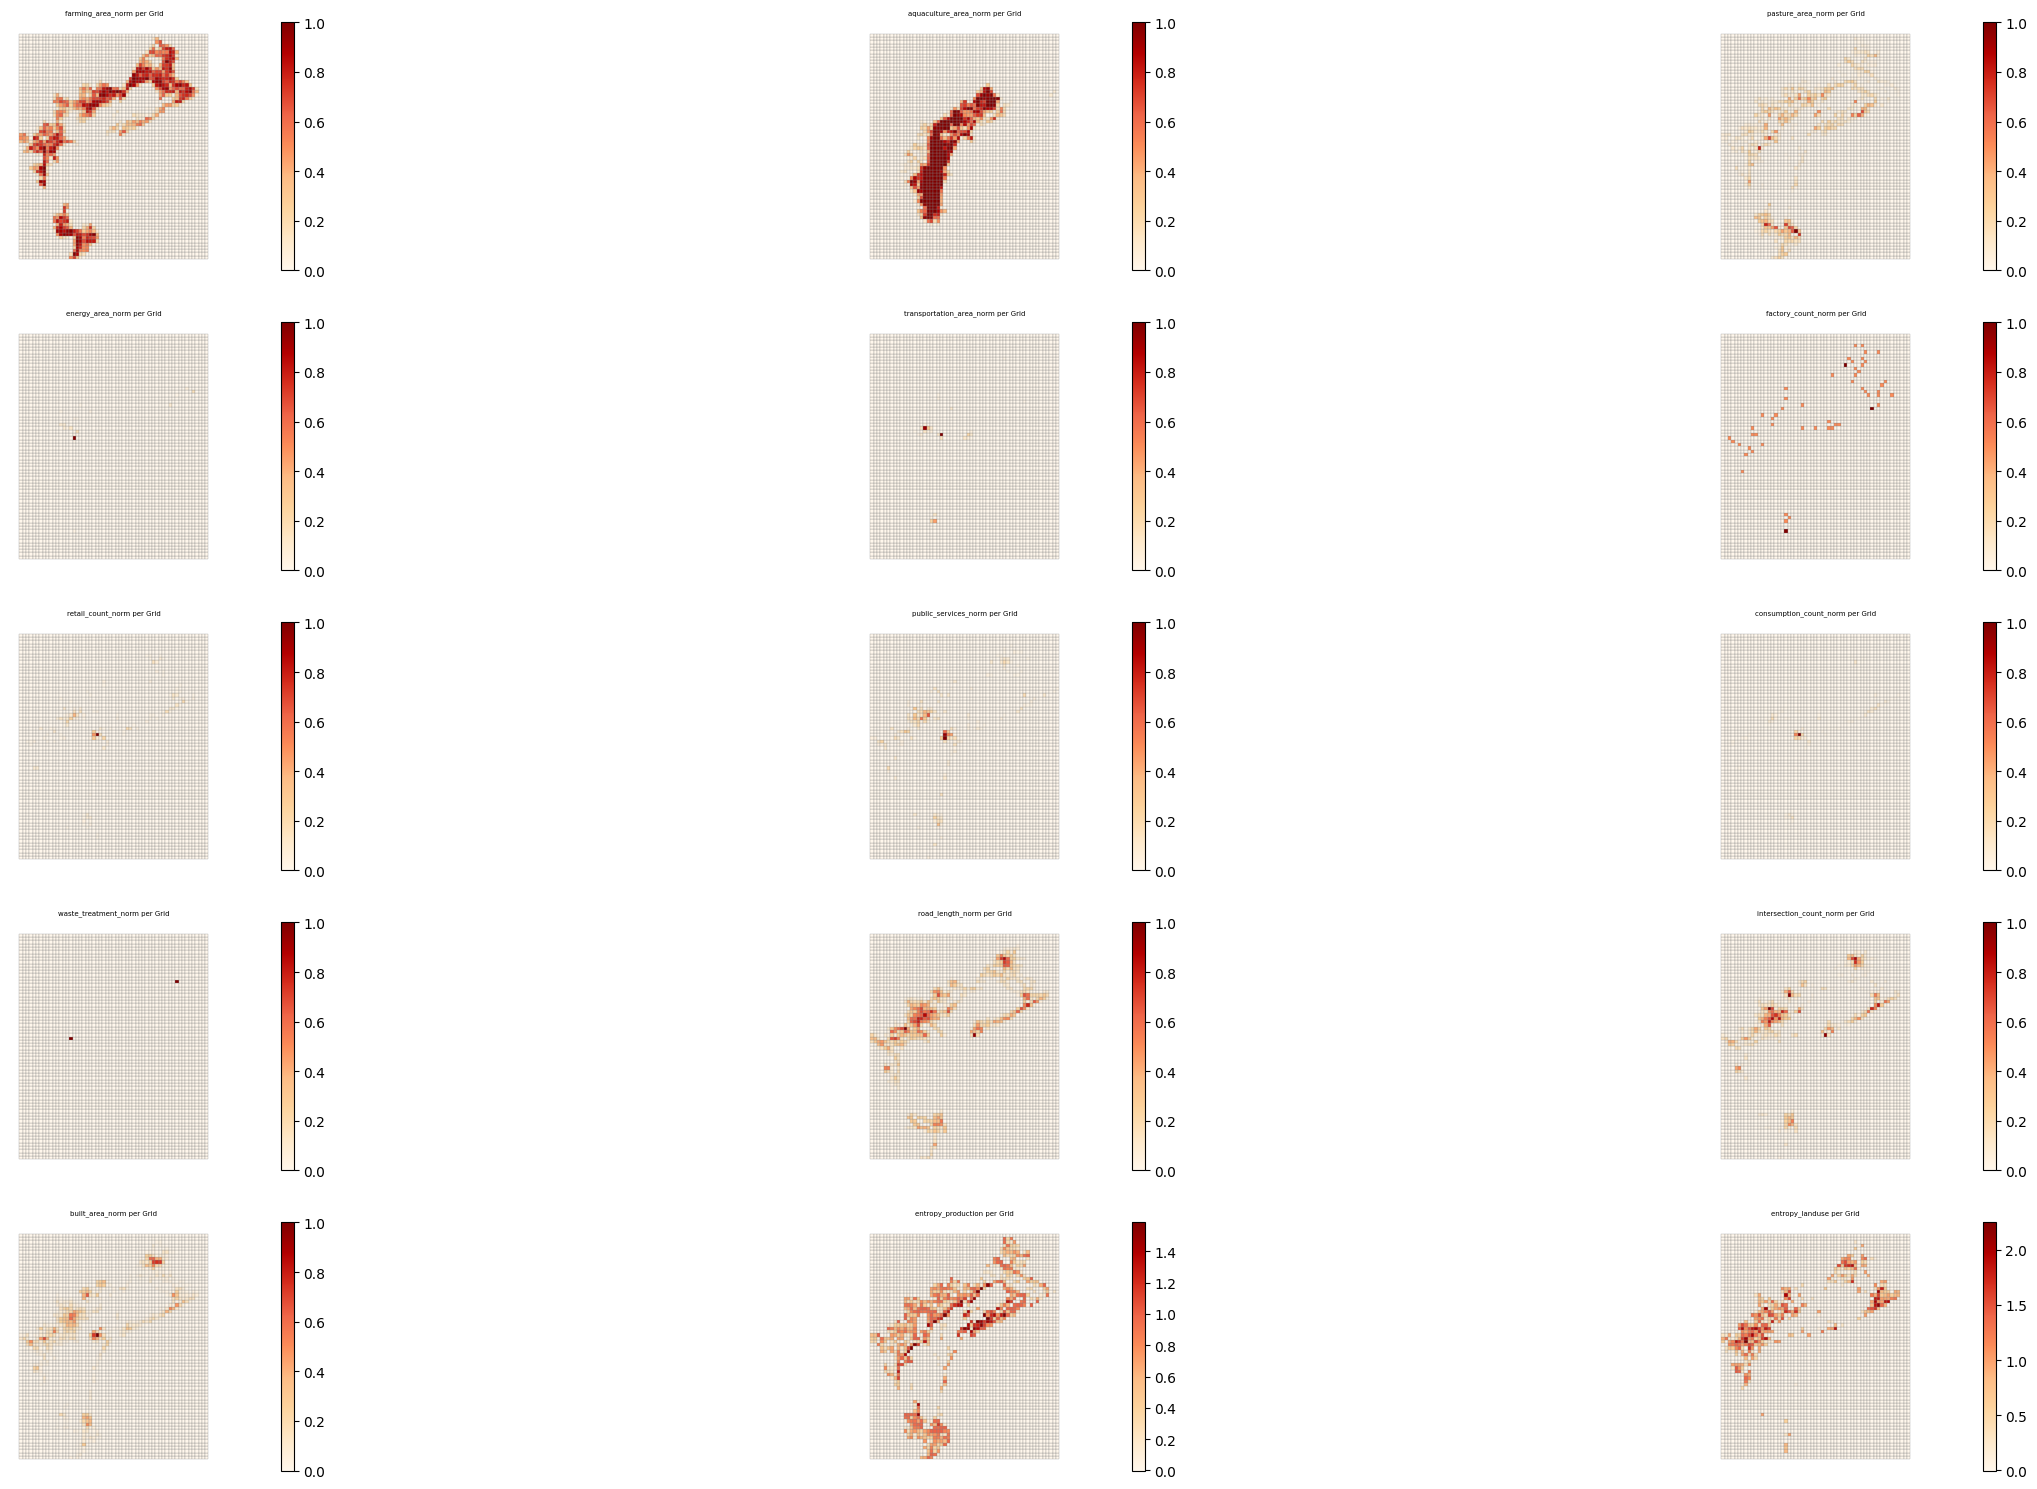

In [7]:
grid_map = gpd.read_file("processing_data\grid\grid_normalized_2500.geojson")
# grid_map = gpd.read_file("processing_data\grid\grid_normalized.geojson")

variables = ['farming_area_norm','aquaculture_area_norm',
       'pasture_area_norm', 'energy_area_norm', 'transportation_area_norm',
       'factory_count_norm', 'retail_count_norm', 'public_services_norm',
       'consumption_count_norm', 'waste_treatment_norm', 'road_length_norm',
       'intersection_count_norm','built_area_norm',
       'entropy_production', 'entropy_landuse']

fig, axs = plt.subplots(5,3, figsize=(30, 15))
axs = axs.flatten()
for i, var in enumerate(variables):
    grid.plot(column=var, ax=axs[i], cmap='OrRd', legend=True, edgecolor='grey', linewidth=0.2)
    axs[i].set_title(f'{var} per Grid', fontsize=5)
    axs[i].axis('off')

plt.tight_layout()
plt.show()

# 相关性分析

      farming_area_norm  aquaculture_area_norm  pasture_area_norm  \
0                   0.0                    0.0                0.0   
1                   0.0                    0.0                0.0   
2                   0.0                    0.0                0.0   
3                   0.0                    0.0                0.0   
4                   0.0                    0.0                0.0   
...                 ...                    ...                ...   
3871                0.0                    0.0                0.0   
3872                0.0                    0.0                0.0   
3873                0.0                    0.0                0.0   
3874                0.0                    0.0                0.0   
3875                0.0                    0.0                0.0   

      energy_area_norm  transportation_area_norm  factory_count_norm  \
0                  0.0                       0.0                 0.0   
1                  0.0     

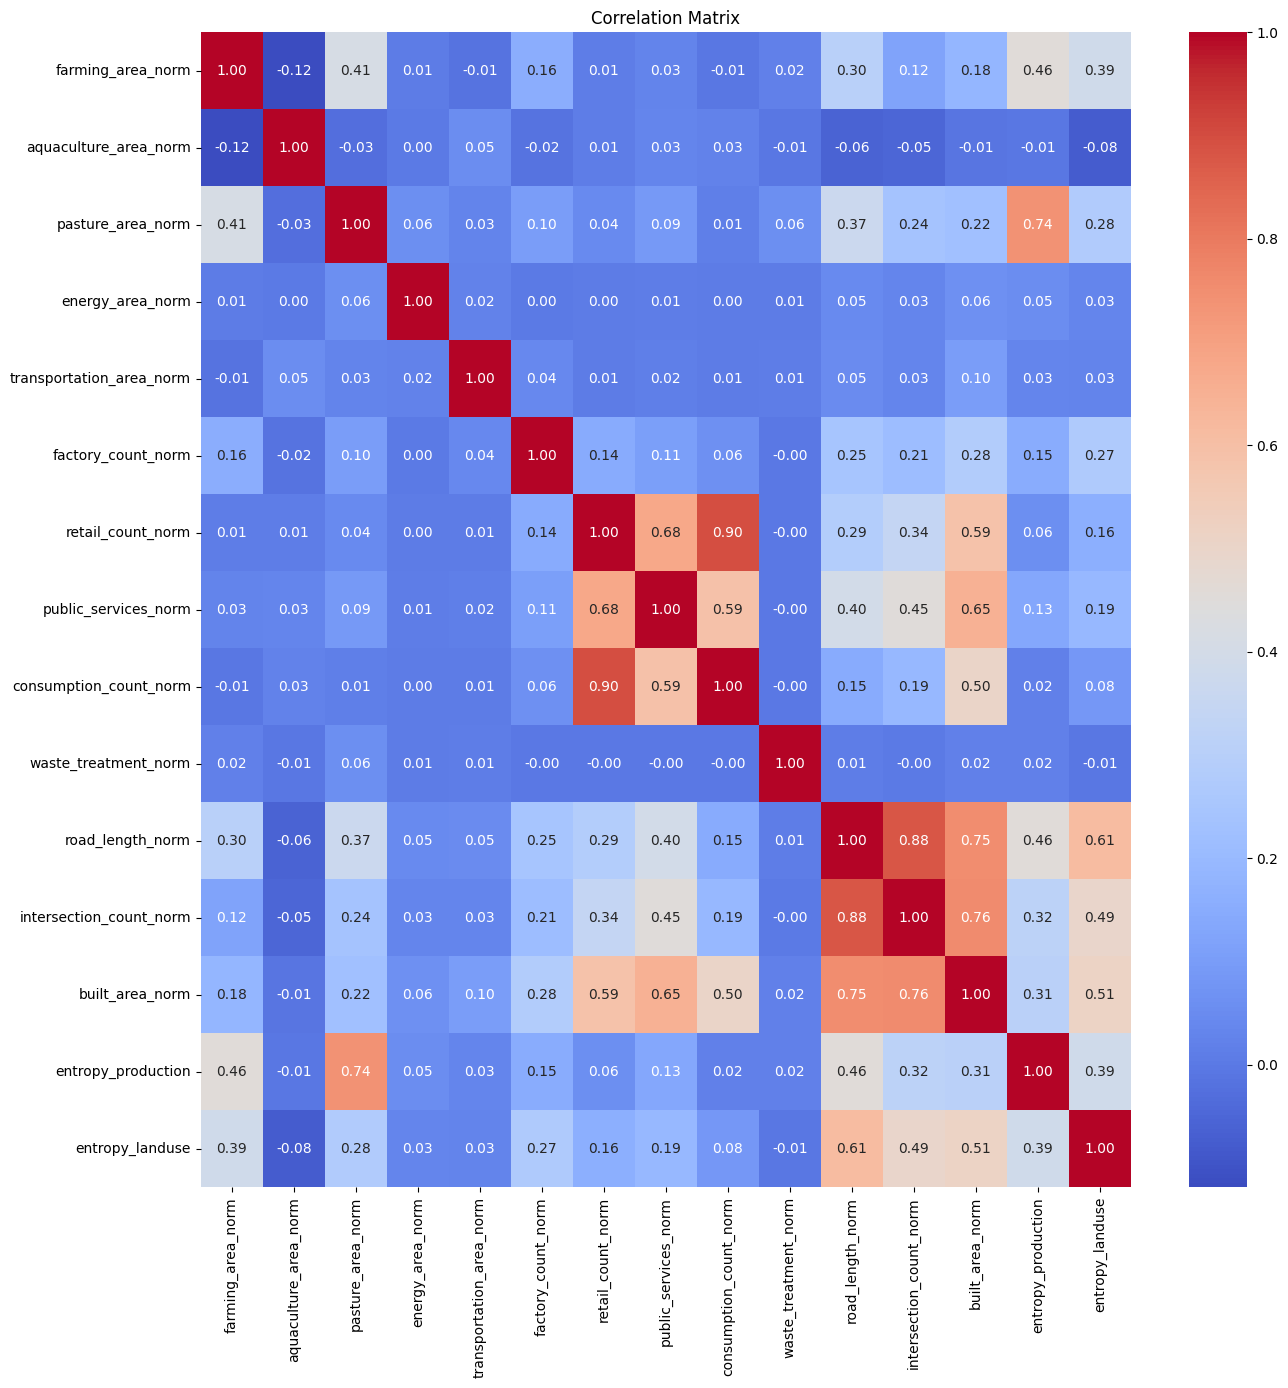

In [8]:
import seaborn as sns
import pandas as pd
grid = gpd.read_file("processing_data\grid\grid_normalized_2500.geojson")
# grid = gpd.read_file("processing_data\grid\grid_normalized.geojson")
# 只提取需要分析的字段
df_analysis = grid[['farming_area_norm','aquaculture_area_norm',
       'pasture_area_norm', 'energy_area_norm', 'transportation_area_norm',
       'factory_count_norm', 'retail_count_norm', 'public_services_norm',
       'consumption_count_norm', 'waste_treatment_norm', 'road_length_norm',
       'intersection_count_norm','built_area_norm',
       'entropy_production', 'entropy_landuse']]
print(df_analysis)
# 计算相关性矩阵
corr_matrix = df_analysis.corr()
corr_matrix.to_csv("correlation_matrix.csv")
# 热力图可视化
plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [9]:
"目前可视化的结果来看：" \
"与 road_length(0.41)、intersection_count(0.34) 的正相关突出表明，加工厂依赖于可达性良好的路网环境" \
"与 built_area(0.42)、public_services(0.38) 高相关，说明 加工厂不在偏远郊区，而常处于有一定基础设施支持的地段" \
"与 retail_count(0.43) 有显著相关，说明“加工厂”不只是原材料初加工，可能还兼顾零售配套，体现产销一体性"




# 回归分析：用 factory_count 为因变量，回归分析各指标，量化每项影响
# 分区分析：结合城市发展等，氛围 城市/城乡/乡村。分别比较相关性
# 更改计算方式，加入 “到道路/市场/港口的平均距离”，更直接衡量可达性

'目前可视化的结果来看：与 road_length(0.41)、intersection_count(0.34) 的正相关突出表明，加工厂依赖于可达性良好的路网环境与 built_area(0.42)、public_services(0.38) 高相关，说明 加工厂不在偏远郊区，而常处于有一定基础设施支持的地段与 retail_count(0.43) 有显著相关，说明“加工厂”不只是原材料初加工，可能还兼顾零售配套，体现产销一体性'